In [18]:
# Standard mathematics and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

# For random sampling during network matrix generation
from numpy.random import default_rng

# For diff. eq. solving via Runge-Kutta 4
from scipy.integrate import odeint

# For activities random sampling according to own power law probability density
from scipy.stats import rv_continuous

# For execution time measurements
import time

# For progress bar
from tqdm import tqdm

In [30]:
# Define classes
class Agent:
    def __init__(self, opinion, activity):
        self.x=opinion
        self.a=activity
        
    def setOpinion(self, opinion):
        self.x=opinion   
        
    def getOpinion(self):
        return self.x
    
    def setActivity(self, activity):
        self.a=activity
    
    def getActivity(self):
        return self.a
        
class Model:
    def __init__(self, N):
        
        x = np.linspace(-1,1,N)
        PowerDistribution = PowerLaw(a=epsilon)
        a = PowerDistribution.rvs(size=N)
        self.network = []
        for i in range(N):
            self.network.append(Agent(x[i], a[i]))
            
    def getNetwork(self):
        return self.network
    
    def getAllOpinions(self):
        allOpinions = np.zeros(len(self.network))
        for i in range(len(self.network)):
            allOpinions[i] = self.network[i].getOpinion()
        return allOpinions
    
    def getAllActivities(self):
        allActivities = np.zeros(len(self.network))
        for i in range(len(self.network)):
            allActivities[i] = self.network[i].getActivity()
        return allActivities
    
    def updateAllOpinions(self, newOpinions):
        if len(self.network) == len(newOpinions):
            for i in range(len(self.network)):
                self.network[i].setOpinion(newOpinions[i])

class PowerLaw(rv_continuous):
    """Activitiy sampling distribution identical to Baumann et al.
    It models the intuitive assumption, that by far most people
    are hardly posting on social media, and even less people being
    very active. 
    

    For Reference, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous"""
    
    # define probability distribution as the paper's "F(a)"
    def _pdf(self, x):
        return ((1-gamma)/(1-epsilon**(1-gamma)))*x**(-1*gamma)


In [31]:
# Define methods

# Implement differential eq. 'dx/dt = [...]' as 'f(t) = [...]' 
def diffEq(x, t, alpha, K):
    sol = np.zeros(N)
    for i in range(N):
        sum_tmp = 0
        for j in range(N):
            sum_tmp = sum_tmp+A[i][j]*np.tanh(alpha*x[j])
        sol[i] = -x[i]+K*sum_tmp
    return sol

def calculateProbabilities(i, j, x, beta):
    sum_tmp = 0
    for j_tmp in range(len(x)):
        if x[i] != x[j_tmp]:
            sum_tmp = sum_tmp+abs(x[i]-x[j_tmp])**(-beta)
    return (abs(x[i]-x[j])**(-beta))/sum_tmp

def generateContactMatrix(x, a, beta, m, r):
    
    # Initialise uniform random number generator [0,1[
    # and create to-be-filled matrix A
    rng = default_rng()
    A = np.zeros((N,N))
    
    # Iterate through every agent
    for i in range(N):
        
        #Test, if agent is activated
        if a[i] > rng.random():
        
            # If activated, calculate each probability p_ij and sample contacted agents
            for j in range(N):
                if i != j:
                    A[j][i] = calculateProbabilities(i, j, x, beta)
                    if m*A[j][i] > rng.random():
                        A[j][i] = 1

                        # Introduce reciprocal contacting, occuring with probability r:
                        if r > rng.random():
                            A[i][j] = 1
    return A

In [42]:
# Define fixed parameters
t_current = 0
tMax = 10
dt = 0.01
N = 100
K=3

# Define different alpha, beta values as arrays from which to pick for each graph
alphas = np.array([0.05, 3, 3])
betas = np.array([2, 0, 3])
alpha_current = alphas[0]
beta_current = betas[0]

# Fixed activity-driving (AD) parameters
m = 10
epsilon = 0.01
gamma = 2.1
r = 0.5


In [43]:
# Initialise agents via Model class and get opinions for start of dynamics
model = Model(N)
opinionStorage = model.getAllOpinions()

execution_start_time = time.time()
print('---\nModel started\n---\n')

# Integrate dynamics with 4th order Runge-Kutta (RK4)
for t in tqdm(np.arange(0, tMax, dt)):
    
    # Update current time
    t_current = t + dt
    
    # Integrate opinion differential equation from t_current-dt to t_current
    currentOpinions = model.getAllOpinions()
    currentActivites = model.getAllActivities()
    t_RK4 = np.linspace(t_current-dt, t_current, 2)
    A = generateContactMatrix(currentOpinions, currentActivites, beta_current, m, r)
    solODE = odeint(diffEq, currentOpinions, t_RK4, args=(alpha_current, K))

    # Update and store new opinions in agents and storage array
    newOpinions = solODE[-1]
    model.updateAllOpinions(newOpinions)
    opinionStorage = np.vstack([opinionStorage, newOpinions])

print('\n---\nModel finished\n---')
execution_end_time = time.time()
print('\n---\nTime needed:\t',execution_end_time-execution_start_time,'\n---')


---
Model started
---



100%|██████████| 1000/1000 [02:25<00:00,  6.89it/s]


---
Model finished
---

---
Time needed:	 145.0835304260254 
---


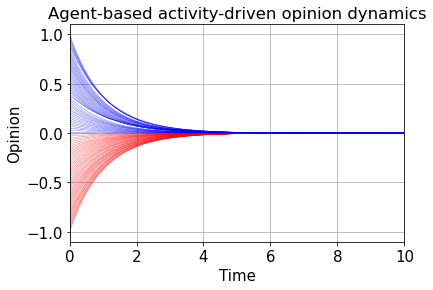

In [44]:
# Plot the results:

# Globally change font size for Matplotlib plots
plt.rcParams.update({'font.size': 15})

# Get time values for plotting out of storage array information
time_finish = len(opinionStorage)*dt
time_0 = 0
times = np.arange(time_0, time_finish, dt)

# Plot each agent via looping over storage array
for i in range(len(opinionStorage.T)):
    
    # In case the last value of agent i is negative, the graph color will be changed to red 
    if opinionStorage.T[i][-1] < 0:
        color = 'r'
    else:
        color ='b'   
    plt.plot(times, opinionStorage.T[i], color, linewidth=.25)

plt.xlabel('Time')
plt.ylabel('Opinion')
plt.title('Agent-based activity-driven opinion dynamics', size=16.5)
plt.grid()
plt.xlim([0,10])
#plt.ylim([-1, 1])
#plt.xticks([0, 5, 10])
#plt.yticks([-5, 0, 5])

# Uncomment if you do want to save the figure:
file_name = 'Dynamics--N='+str(N)+'--alpha='+str(alpha_current)+'--beta='+str(beta_current)
np.savetxt(str(file_name+'.txt'), opinionStorage.T)
plt.savefig(str(file_name+'.png'))
plt.show()


In [45]:
# The following includes the whole script routine,
# working over every value of the "alphas", "betas" arrays
# and saving each graph.

# Define fixed parameters
t_current = 0
tMax = 10
dt = 0.01
N = 100
K=3

# Define different alpha, beta values as arrays from which to pick for each graph
alphas = np.array([0.05, 3, 3])
betas = np.array([2, 0, 3])
alpha_current = alphas[0]
beta_current = betas[0]

# Fixed activity-driving (AD) parameters
m = 10
epsilon = 0.01
gamma = 2.1
r = 0.5


# Initialise and run model in the following:
for i in range(len(alphas)):
    
    # Set current time to start time 0, set alpha and beta parameters
    t_current = 0
    alpha_current = alphas[i]
    beta_current = betas[i]
    
    # Initialise agents via Model class and get opinions for start of dynamics
    model = Model(N)
    opinionStorage = model.getAllOpinions()

    execution_start_time = time.time()
    print('---\nModel started\n---\n')

    # Integrate dynamics with 4th order Runge-Kutta (RK4)
    for t in tqdm(np.arange(0, tMax, dt)):
        
        # Update current time
        t_current = t + dt
        
        # Integrate opinion differential equation from t_current-dt to t_current
        currentOpinions = model.getAllOpinions()
        t_RK4 = np.linspace(t_current-dt, t_current, 2)
        A = generateContactMatrix(currentOpinions, beta_current, m, r)
        solODE = odeint(diffEq, currentOpinions, t_RK4, args=(alpha_current, K))

        # Update and store new opinions in agents and storage array
        newOpinions = solODE[-1]
        model.updateAllOpinions(newOpinions)
        opinionStorage = np.vstack([opinionStorage, newOpinions])

    print('\n---\nModel finished\n---')
    execution_end_time = time.time()
    print('\n---\nTime needed:\t',execution_end_time-execution_start_time,'\n---')



    # Plot the results:

    # Globally change font size for Matplotlib plots
    plt.rcParams.update({'font.size': 15})

    # Get time values for plotting out of storage array information
    time_finish = len(opinionStorage)*dt
    time_0 = 0
    times = np.arange(time_0, time_finish, dt)

    # Plot each agent via looping over storage array
    for i in range(len(opinionStorage.T)):
        
        # In case the last value of agent i is negative, the graph color will be changed to red 
        if opinionStorage.T[i][-1] < 0:
            color = 'r'
        else:
            color ='b'   
        plt.plot(times, opinionStorage.T[i], color, linewidth=.25)

    plt.xlabel('Time')
    plt.ylabel('Opinion')
    plt.title('Agent-based activity-driven opinion dynamics', size=16.5)
    plt.grid()
    plt.xlim([0,10])
    
    #plt.ylim([-1, 1])
    #plt.xticks([0, 5, 10])
    #plt.yticks([-5, 0, 5])

    # Uncomment if you do want to save the figure:
    file_name = 'Dynamics--N='+str(N)+'--alpha='+str(alpha_current)+'--beta='+str(beta_current)
    np.savetxt(str(file_name+'.txt'), opinionStorage.T)
    plt.savefig(str(file_name+'.png'))
    plt.show()

---
Model started
---



  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: generateContactMatrix() missing 1 required positional argument: 'r'